In [ ]:
!pip install imgaug tensorflow keras

In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d harshpatel66/mpii-human-pose

In [3]:
!unzip -qq /content/mpii-human-pose.zip

In [1]:
from tensorflow import keras
import tensorflow as tf

from keras.callbacks import ModelCheckpoint
from keras import layers

from torch.utils.data import Dataset, DataLoader

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

from PIL import Image
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json
import cv2
import os

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 5
NUM_KEYPOINTS = 17 * 2  # 17 pairs each having x and y coordinates

In [3]:
IMG_DIR = "/content/mpii_human_pose_v1/images/"
JSON = "/content/mpii_annotations.json"
KEYPOINT_DEF = "/content/mpii_human_pose.csv"

# Load the ground-truth annotations.
with open(JSON) as infile:
    json_data = json.load(infile)

# Set up a dictionary, mapping all the ground-truth information
# with respect to the path of the image.
json_dict_resized = {i["img_paths"]: i for i in json_data}

for name in json_dict_resized.keys():
    for temp in json_dict_resized[name]["joint_self"]:
        temp[0] = round((temp[0] / json_dict_resized[name]["img_width"]) * IMG_SIZE)
        temp[1] = round((temp[1] / json_dict_resized[name]["img_height"]) * IMG_SIZE)

    json_dict_resized[name]["objpos"] = round((json_dict_resized[name]["objpos"][0] / json_dict_resized[name]["img_width"]) * IMG_SIZE), \
                                        round((json_dict_resized[name]["objpos"][1] / json_dict_resized[name]["img_height"]) * IMG_SIZE)

    json_dict_resized[name]["img_width"] = 224
    json_dict_resized[name]["img_height"] = 224

In [4]:
# Load the ground-truth annotations.
with open(JSON) as infile:
    json_data = json.load(infile)

json_dict = {i["img_paths"]: i for i in json_data}

In [5]:
# Load the metdata definition file and preview it.
keypoint_def = pd.read_csv(KEYPOINT_DEF)
keypoint_def.head()

,ID,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,1,015601864.jpg,620,394,616,269,573,185,647,188,...,167,692,185,693,240,688,313,3.021046,curling,sports
1,2,015599452.jpg,-1,-1,-1,-1,806,543,720,593,...,281,719,299,711,516,545,466,5.641276,curling,sports
2,3,005808361.jpg,804,711,816,510,908,438,1040,454,...,253,1067,253,1167,353,1142,478,4.718488,curling,sports
3,4,086617615.jpg,301,461,305,375,201,340,294,342,...,261,314,264,327,320,362,346,2.681349,curling,sports
4,5,060111501.jpg,980,322,896,318,865,248,943,226,...,147,923,123,995,163,961,223,3.806403,curling,sports


In [6]:
# Utility for reading an image and for getting its annotations.
def get_photos(name):
    data = json_dict_resized[name]
    img_data = plt.imread(os.path.join(IMG_DIR, data["img_paths"]))

    img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
    # If the image is RGBA convert it to RGB.
    if img_data.shape[-1] == 4:
        img_data = img_data.astype(np.uint8)
        img_data = Image.fromarray(img_data)
        img_data = np.array(img_data.convert("RGB"))
    data["img_data"] = img_data

    return data

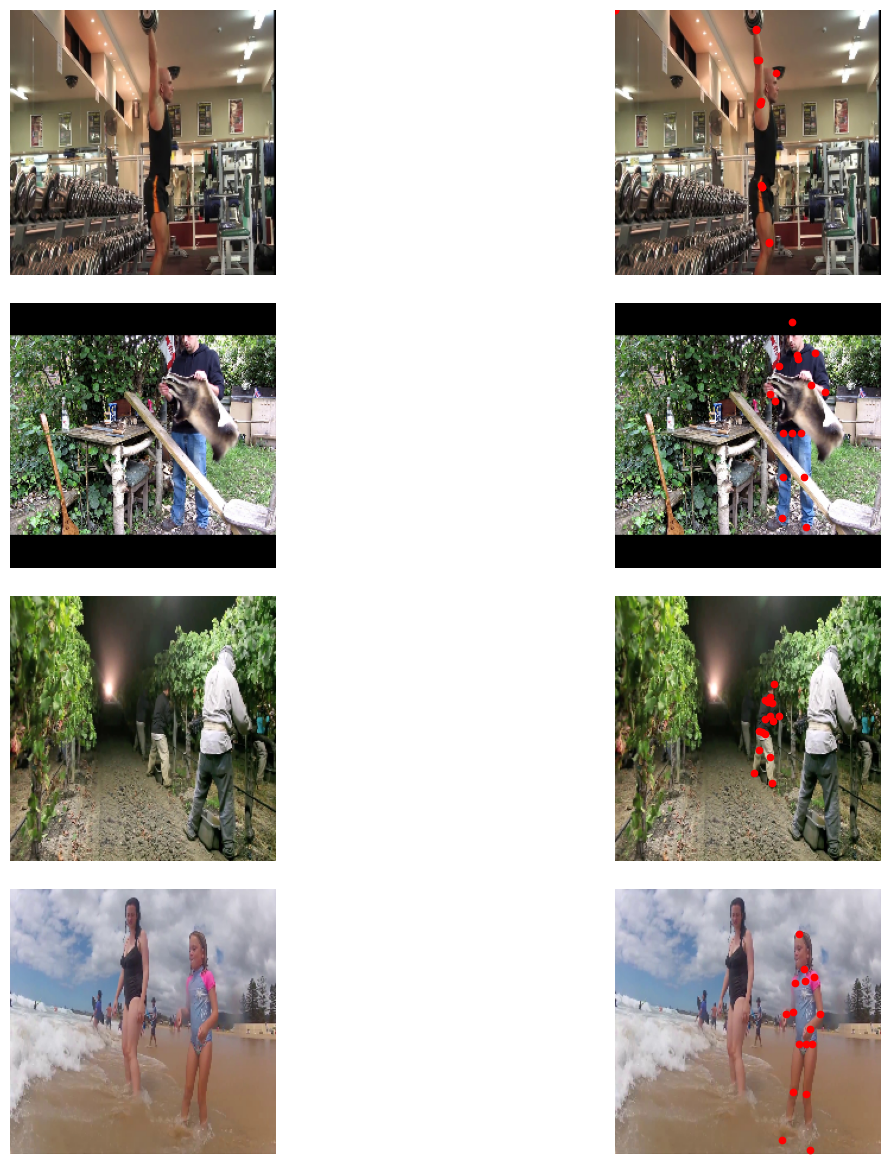

In [7]:
# Parts of this code come from here:
# https://github.com/benjiebob/StanfordExtra/blob/master/demo.ipynb
def visualize_keypoints(images, keypoints):
    fig, axes = plt.subplots(nrows=len(images), ncols=2, figsize=(16, 12))
    [ax.axis("off") for ax in np.ravel(axes)]

    for (ax_orig, ax_all), image, current_keypoint in zip(axes, images, keypoints):
        ax_orig.imshow(image)
        ax_all.imshow(image)

        # If the keypoints were formed by `imgaug` then the coordinates need
        # to be iterated differently.
        if isinstance(current_keypoint, KeypointsOnImage):
            for idx, kp in enumerate(current_keypoint.keypoints):
                ax_all.scatter(
                    [kp.x], [kp.y], c='red', marker=".", s=50, linewidths=2
                )
        else:
            current_keypoint = np.array(current_keypoint)
            # Since the last entry is the visibility flag, we discard it.
            current_keypoint = current_keypoint[:, :2]
            for idx, (x, y) in enumerate(current_keypoint):
                ax_all.scatter([x], [y], c='red', marker=".", s=50, linewidths=2)

    plt.tight_layout(pad=2.0)
    plt.show()


# Select four samples randomly for visualization.
samples = list(json_dict.keys())
num_samples = 4
selected_samples = np.random.choice(samples, num_samples, replace=False)

images, keypoints = [], []

for sample in selected_samples:
    data = get_photos(sample)
    image = data["img_data"]
    keypoint = data["joint_self"]

    images.append(image)
    keypoints.append(keypoint)

visualize_keypoints(images, keypoints)

In [8]:
class KeyPointsDataset(keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_keys = image_keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys))
        if self.train:
            np.random.shuffle(self.indexes)

    def __iter__(self):
        for i in range(self.__len__()):
            yield self.__getitem__(i)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [self.image_keys[k] for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i, key in enumerate(image_keys_temp):
            data = get_photos(key)
            current_keypoint = np.array(data["joint_self"])[:, :2]
            kps = []

            # To apply our data augmentation pipeline, we first need to
            # form Keypoint objects with the original coordinates.
            for j in range(0, len(current_keypoint)):
                kps.append(Keypoint(x=current_keypoint[j][0], y=current_keypoint[j][1]))

            # We then project the original image and its keypoint coordinates.
            current_image = data["img_data"]
            kps_obj = KeypointsOnImage(kps, shape=current_image.shape)

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))

            # More on why this reshaping later.
            num_keypoints = len(kp_temp) // 2
            # Pad or truncate kp_temp to have the desired length (34)
            kp_temp = kp_temp + [0] * (34 - len(kp_temp)) if len(kp_temp) < 34 else kp_temp[:34]

            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 34)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints)

In [9]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        # `Sometimes()` applies a function randomly to the inputs with
        # a given probability (0.3, in this case).
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7))),
    ]
)

test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [10]:
np.random.shuffle(samples)
train_keys, validation_keys = (
    samples[int(len(samples) * 0.15) :],
    samples[: int(len(samples) * 0.15)],
)

Total batches in training set: 231
Total batches in validation set: 40


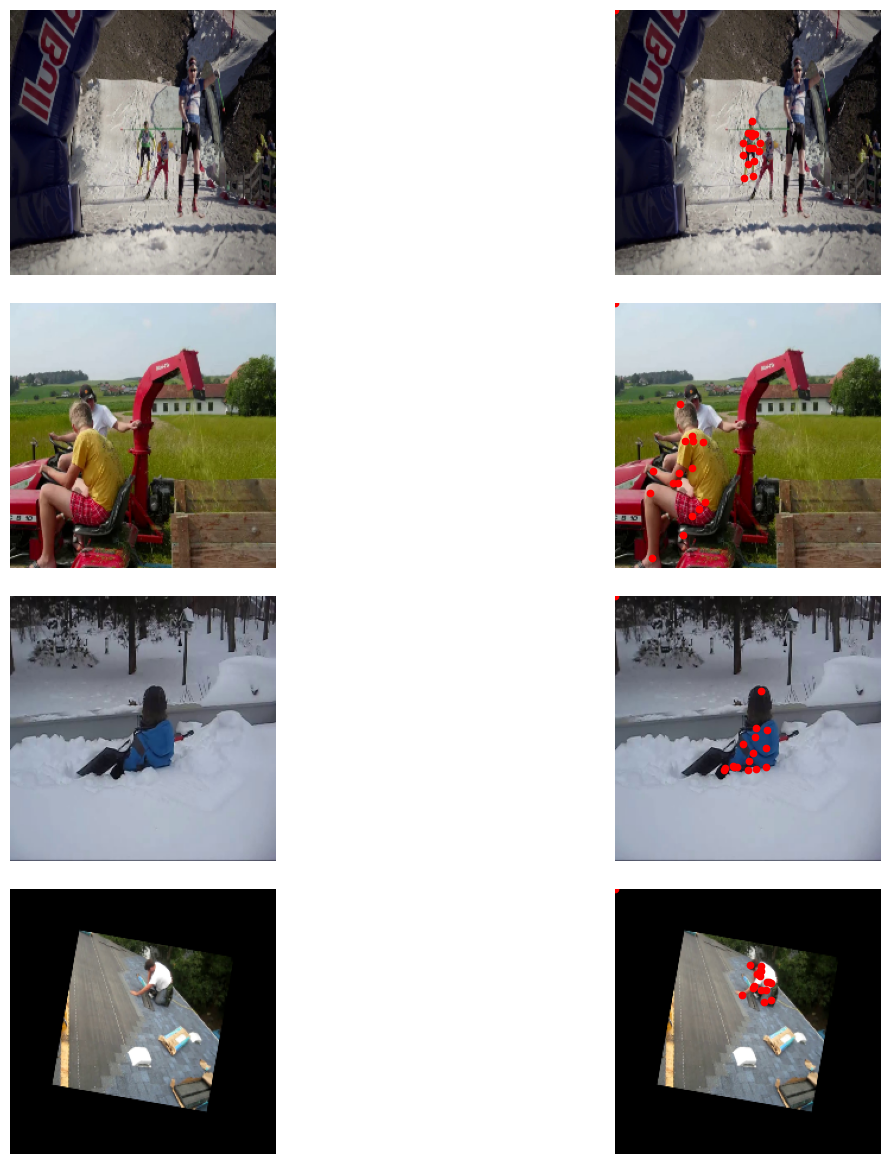

In [11]:
train_dataset = KeyPointsDataset(train_keys, train_aug)
validation_dataset = KeyPointsDataset(validation_keys, test_aug, train=False)

print(f"Total batches in training set: {len(train_dataset)}")
print(f"Total batches in validation set: {len(validation_dataset)}")

sample_images, sample_keypoints = next(iter(train_dataset))
assert sample_keypoints.max() == 1.0
assert sample_keypoints.min() == 0.0

sample_keypoints = sample_keypoints[:4].reshape(-1, 17, 2) * IMG_SIZE
visualize_keypoints(sample_images[:4], sample_keypoints)

In [12]:
def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
    )(x)
    outputs = layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=1, activation="sigmoid"
    )(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [13]:
model = get_model()
model.compile(loss="mse", optimizer=keras.optimizers.Adam(1e-4))
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=2
)

Epoch 1/2
231/231 [==============================] - 347s 1s/step - loss: 0.0476 - val_loss: 0.0453
Epoch 2/2
231/231 [==============================] - 330s 1s/step - loss: 0.0361 - val_loss: 0.0414


1/1 [==============================] - 1s 1s/step


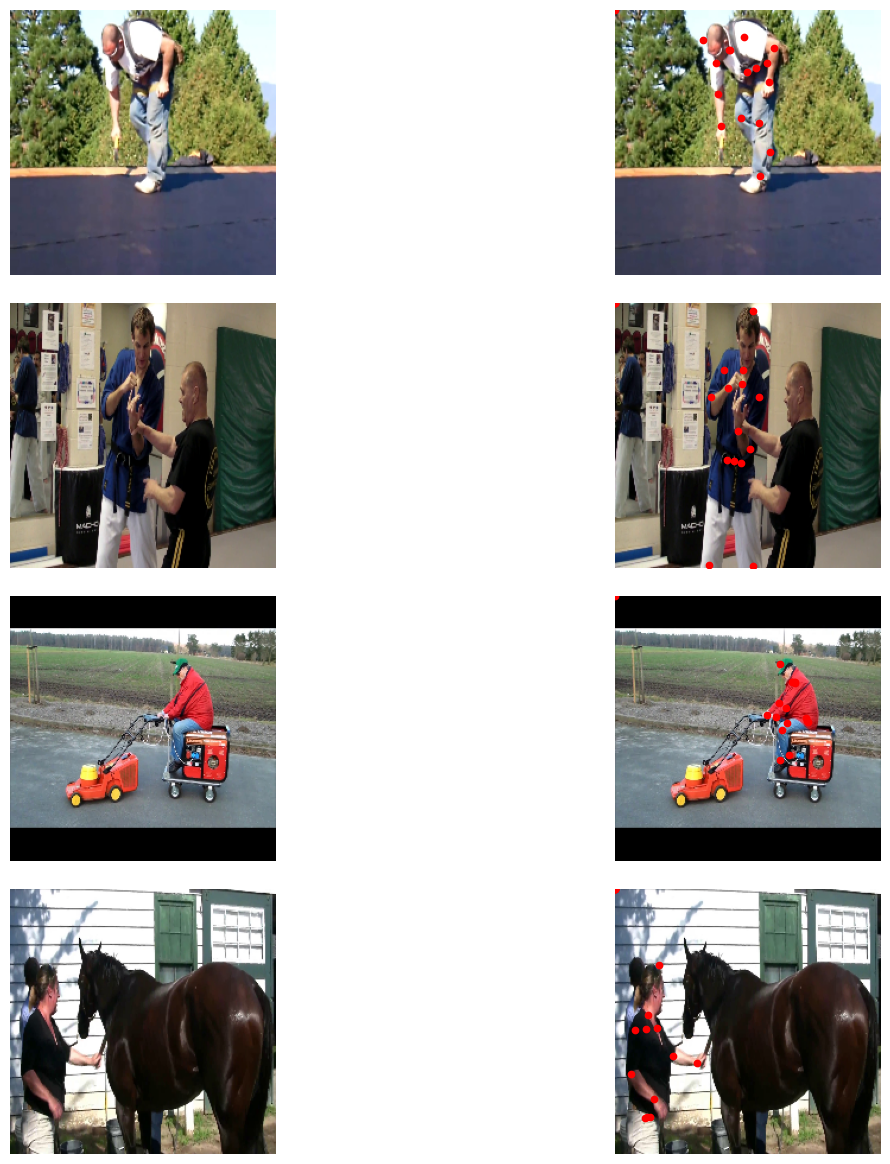

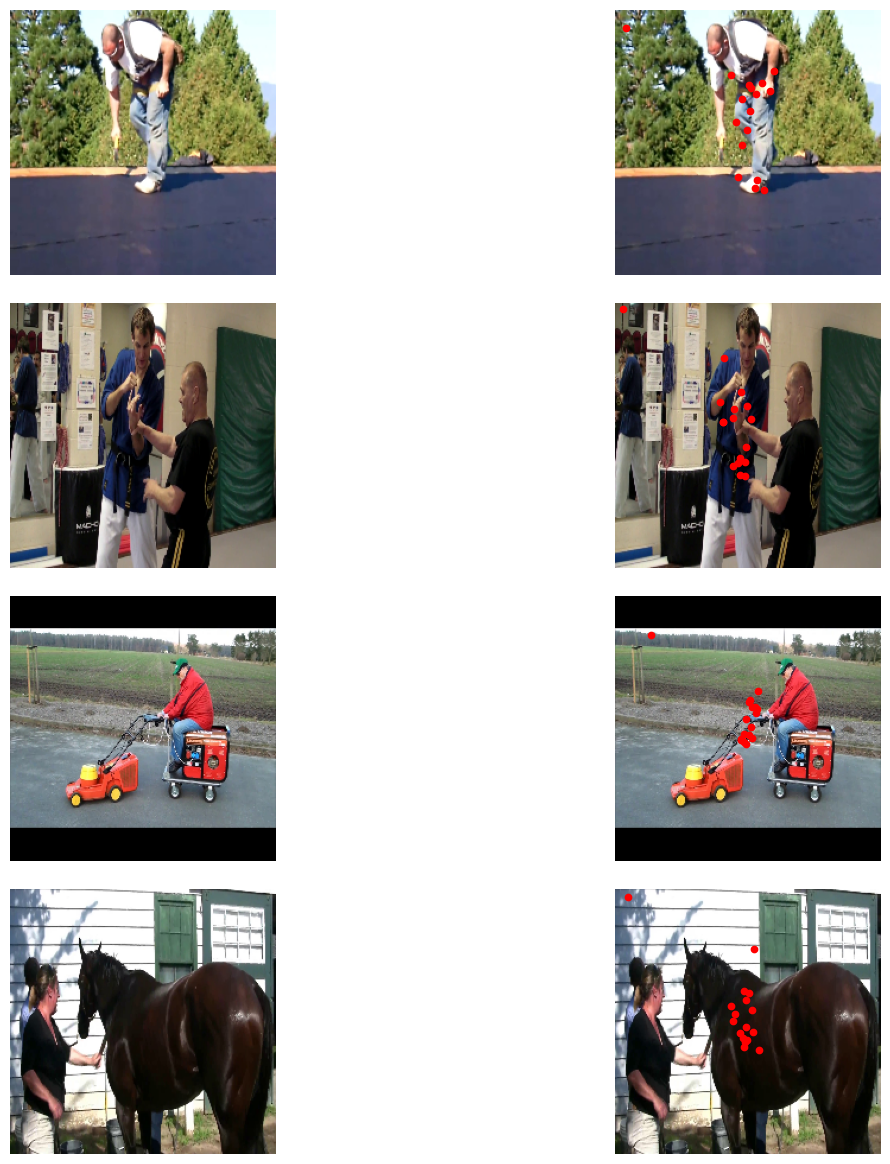

In [14]:
sample_val_images, sample_val_keypoints = next(iter(validation_dataset))
sample_val_images = sample_val_images[:4]
sample_val_keypoints = sample_val_keypoints[:4].reshape(-1, 17, 2) * IMG_SIZE
predictions = model.predict(sample_val_images).reshape(-1, 17, 2) * IMG_SIZE

# Ground-truth
visualize_keypoints(sample_val_images, sample_val_keypoints)

# Predictions
visualize_keypoints(sample_val_images, predictions)

In [15]:
model.save("test.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
